<a href="https://colab.research.google.com/github/InfectionMedicineProteomics/BINN/blob/main/colab/BINN_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/InfectionMedicineProteomics/BINN/main/docs/img/logo.png" height="150" align="right" style="height:240px">

# BINN v0.1.0 notebook

This notebook allows you to create, train and explain **biologically informed neural networks (BINNs)** on your own datasets. Just upload your data and follow the instructions below!

[Erik Hartman, Aaron M. Scott, Christofer Karlsson, Tirthankar Mohanty, Suvi T. Vaara, Adam Linder, Lars Malmström & Johan Malmström. Interpreting biologically informed neural networks for enhanced proteomic biomarker discovery and pathway analysis
*Nature Communications*, 2023](https://www.nature.com/articles/s41467-023-41146-4)

## 0. Install

In [1]:
import os
# Install the BINN package from GitHub
if not os.path.exists("/content/BINN"):
  print("Downloading BINN")
  !git clone --single-branch --branch main https://github.com/InfectionMedicineProteomics/BINN.git
else:
  print("BINN is already downloaded")
print("Installing BINN")
!pip install -q -e  BINN
print("Note that you may have to restart runtime after installation.")

BINN is already downloaded
Installing BINN
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for binn (pyproject.toml) ... done
Note that you may have to restart runtime after installation.


<img src="https://raw.githubusercontent.com/InfectionMedicineProteomics/BINN/main/docs/img/data_explanation.png" height="300" align="right" style="height:240px">

## 1. Upload data

The BINN takes 4 files:
1. Your datamatrix
2. Your design matrix
3. Optional: a file describing the pathways which will be used to build the network.
4. Optional: a mapping between the input format and the pathway format.

Instead of providing 3 and 4, you can use pre-loaded pathway files. We currently support input in the format of UniProt IDs or miRBase and the Reactome pathway database for the underlying structure.

In [2]:
import os
import pandas as pd
from google.colab import files

# @markdown ### Job name
job_name = "binn_job" # @param {type:"string"}

# @markdown ---

# @markdown ### Input source: `uniprot`, `mirbase` or `custom`.  If `custom` you need will be prompted to upload your own mapping file
input_source = "uniprot"  # @param ["uniprot", "mirbase", "custom"]

# @markdown ### Pathways File Options: `reactome` or `custom`. If `custom` you need will be prompted to upload your own pathway file
pathways_source = "reactome"  # @param ["reactome", "custom"]

# @markdown ---
# @markdown ### Entity column in data matrix.  This should match in your data file.
entity_column = "Protein"  # @param {type:"string"}
# @markdown ---

# @markdown ### Sample and group columns in design matrix. This should match in the header in your design file.
group_column = "group"  # @param {type:"string"}
sample_column = "sample"  # @param {type:"string"}
# @markdown ---

# @markdown ### Source and target columns in pathways file. This should match the header in your pathways file.
source_column = "source"  # @param {type:"string"}
target_column = "target"  # @param {type:"string"}
# @markdown ---

# @markdown ### Input and translation columns in mapping file. This should match the header in your mapping file.
input_column = "input"  # @param {type:"string"}
translation_column = "translation"  # @param {type:"string"}


def read_file(file):
  filename = list(file.keys())[0]
  if filename.endswith(".tsv"):
    return pd.read_csv(filename, sep="\t")
  elif filename.endswith(".csv"):
    return pd.read_csv(filename)

print("Please upload your input datamatrix:")
datamatrix = read_file(files.upload())

print("Please upload your input designmatrix:")
designmatrix = read_file(files.upload())

def validate_columns(df, required_cols, df_name):
    """
    Check if required columns exist in the DataFrame.
    Raise ValueError if any are missing.
    """
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(
            f"Missing columns {missing} in {df_name}. "
            f"Columns found: {list(df.columns)}"
        )


if input_source == "custom":
  print("Please upload your custom mapping file:")
  uploaded_mapping = files.upload()
  mapping = read_file(uploaded_mapping)
  print(f"Loaded custom mapping file")
  validate_columns(mapping, [source_column, target_column], "mapping")


if pathways_source == "custom":
  print("Please upload your custom pathways file:")
  uploaded_pathways = files.upload()
  pathways = read_file(uploaded_pathways)
  print(f"Loaded custom pathways file")
  validate_columns(pathways, [input_column, translation_column], "pathways")



Please upload your input datamatrix:


Saving sample_datamatrix.csv to sample_datamatrix (1).csv
Please upload your input designmatrix:


Saving sample_design_matrix.tsv to sample_design_matrix (1).tsv


## 2. Configure the BINN

In [3]:
# @markdown ### BINN options

n_layers = 4  # @param {type:"integer"}
n_outputs = 2  # @param {type:"integer"}
activation = "tanh" # @param

# @markdown ---
# @markdown ### Training options

num_epochs = 50  # @param {type:"integer"}
batch_size = 32  # @param {type:"integer"}
validation_split = .2  # @param {type:"slider", min:0, max:1, step:0.01}

In [4]:
# @title ## 3. Train the BINN!
# Initialize the BINN model
from binn import BINN, BINNDataLoader, BINNTrainer

if input_source == "uniprot" and pathways_source == "reactome":
  binn = BINN(data_matrix=datamatrix, network_source="reactome", input_source="uniprot", device="cpu"
  , n_outputs=n_outputs, n_layers=n_layers, activation=activation)
else:
  binn = BINN(data_matrix=datamatrix, mapping=mapping, pathways=pathways, device="cpu",
              n_outputs=n_outputs, n_layers=n_layers, activation=activation,
              input_col=input_column, target_col=target_column, entity_col=entity_column,
              source_col=source_column, translation_col=translation_column)


binn_dataloader = BINNDataLoader(binn)

dataloaders = binn_dataloader.create_dataloaders(
    data_matrix=datamatrix,
    design_matrix=designmatrix,
    feature_column=entity_column,
    group_column=group_column,
    sample_column=sample_column,
    batch_size=batch_size,
    validation_split=validation_split,
)

# Initialize the trainer
trainer = BINNTrainer(binn)

# Train the model
trainer.fit(dataloaders=dataloaders, num_epochs=num_epochs)


[INFO] BINN is on device: cpu
Mapping group labels: {1: 0, 2: 1}
[Epoch 1/50] Train Loss: 0.6169, Train Accuracy: 0.6797
[Epoch 1/50] Val Loss: 0.6928, Val Accuracy: 0.5312
[Epoch 2/50] Train Loss: 0.5759, Train Accuracy: 0.7185
[Epoch 2/50] Val Loss: 0.6924, Val Accuracy: 0.5312
[Epoch 3/50] Train Loss: 0.5612, Train Accuracy: 0.7080
[Epoch 3/50] Val Loss: 0.6920, Val Accuracy: 0.5312
[Epoch 4/50] Train Loss: 0.5373, Train Accuracy: 0.7418
[Epoch 4/50] Val Loss: 0.6913, Val Accuracy: 0.5312
[Epoch 5/50] Train Loss: 0.5223, Train Accuracy: 0.7711
[Epoch 5/50] Val Loss: 0.6899, Val Accuracy: 0.5312
[Epoch 6/50] Train Loss: 0.4861, Train Accuracy: 0.7636
[Epoch 6/50] Val Loss: 0.6867, Val Accuracy: 0.5312
[Epoch 7/50] Train Loss: 0.4599, Train Accuracy: 0.8099
[Epoch 7/50] Val Loss: 0.6791, Val Accuracy: 0.5938
[Epoch 8/50] Train Loss: 0.4552, Train Accuracy: 0.7905
[Epoch 8/50] Val Loss: 0.6632, Val Accuracy: 0.7656
[Epoch 9/50] Train Loss: 0.3980, Train Accuracy: 0.8224
[Epoch 9/50] V

## 4. Explain the BINN Model

In [5]:
# @markdown ### Explainer options

single_or_average = "single"  # @param ["single", "average"]
normalization_method = "fan"  # @param ["subgraph", "fan"]

# @markdown ---

# @markdown ### Options for average explainer
n_iterations = 3  # @param {type:"integer"}
num_epochs_explain = 50 # @param {type:"integer"}

from binn import BINNExplainer

explainer = BINNExplainer(binn)

if single_or_average == "average":
  explanations = explainer.explain(
      dataloaders,
      nr_iterations=n_iterations,
      trainer=trainer,
      num_epochs=num_epochs_explain,
      normalization_method=normalization_method
  )
else:
  explanations = explainer.explain_single(dataloaders, split=None, normalization_method=normalization_method)
explanations.to_csv(f"/content/{job_name}.csv")
explanations


,source_layer,target_layer,source_node,target_node,class_idx,importance,normalized_importance
0,0,1,A0M8Q6,R-HSA-166663,0,0.030205,0.007551
1,0,1,A0M8Q6,R-HSA-166663,1,0.040841,0.010210
2,0,1,A0M8Q6,R-HSA-198933,0,0.030205,0.007551
3,0,1,A0M8Q6,R-HSA-198933,1,0.040841,0.010210
4,0,1,A0M8Q6,R-HSA-2029481,0,0.030205,0.007551
...,...,...,...,...,...,...,...
7079,4,5,R-HSA-9612973,output_node,1,0.214049,0.092186
7080,4,5,R-HSA-9709957,output_node,0,0.267749,0.133874
7081,4,5,R-HSA-9709957,output_node,1,0.085379,0.042690
7082,4,5,R-HSA-9748784,output_node,0,0.059161,0.019720


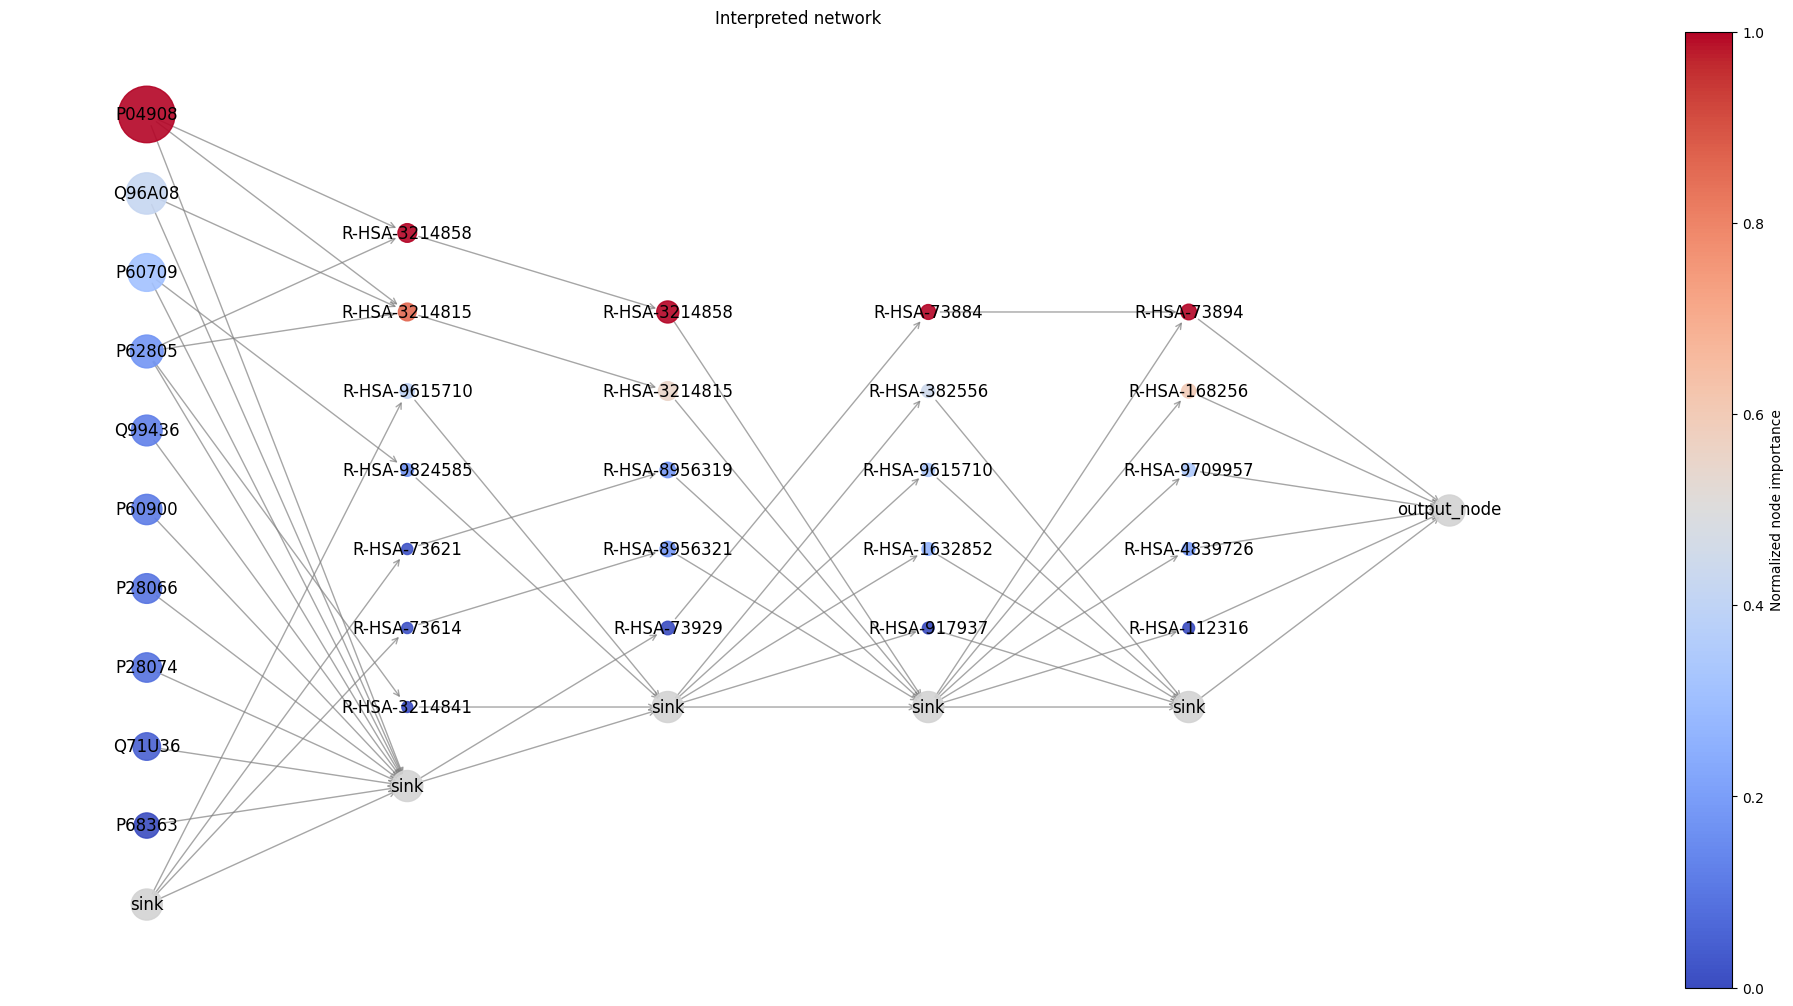

In [6]:
# @title ## 5. Plot
from binn.plot.network import visualize_binn

layer_specific_top_n = {"0": 10, "1": 7, "2": 5, "3": 5, "4": 5}

plt = visualize_binn(
    explanations,
    top_n=layer_specific_top_n,
    plot_size=(20, 10),
    sink_node_size=500,
    node_size_scaling=200,
    edge_width=1,
    node_cmap="coolwarm"
)

plt.title("Interpreted network")
plt.show()

In [7]:
# @title ## 6. Download
files.download(f"/content/{job_name}.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>